In [1359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [1540]:
gameTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedGameData.csv')
dvoaTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedDvoaData.csv', encoding='windows-1252')
pffTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedPffData.csv')

In [1541]:
# First, turn date cols into dt objects
gameTable['date'] = pd.to_datetime(gameTable['date'])
pffTable['date'] = pd.to_datetime(pffTable['date'])

In [1542]:
# Create a table of running averages for pff grades and game scores. Use previous 5-game averages for a team's variables
rollAvgPff = pffTable.set_index('date')

rollAvgPff['avgPf'] = rollAvgPff.groupby('team')['pf'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPa'] = rollAvgPff.groupby('team')['pa'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgOvr'] = rollAvgPff.groupby('team')['overall'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgOff'] = rollAvgPff.groupby('team')['off'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPass'] = rollAvgPff.groupby('team')['pass'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPblk'] = rollAvgPff.groupby('team')['pblk'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRecv'] = rollAvgPff.groupby('team')['recv'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRun'] = rollAvgPff.groupby('team')['run'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRblk'] = rollAvgPff.groupby('team')['rblk'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgDef'] = rollAvgPff.groupby('team')['def'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRdef'] = rollAvgPff.groupby('team')['rdef'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgTack'] = rollAvgPff.groupby('team')['tack'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPrsh'] = rollAvgPff.groupby('team')['prsh'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgCov'] = rollAvgPff.groupby('team')['cov'].apply(lambda x: x.shift(1).rolling(window=7).mean())

rollAvgPff = rollAvgPff.fillna(method='bfill')
rollAvgPff = rollAvgPff.reset_index()

In [1543]:
# Need to make new rollingAvgPff tables that have all dates covered... Dates in pff table are off by one or two days
# Strategy is to create new df's that have all dates, then join the normal pff table to each of them by date,
# then merge all the tables together. All dates will be in the final table
pffB1 = rollAvgPff.copy()
pffB1['date'] = pffB1['date'] - datetime.timedelta(days=1)
pffB2 = rollAvgPff.copy()
pffB2['date'] = pffB2['date'] - datetime.timedelta(days=2)
pffF1 = rollAvgPff.copy()
pffF1['date'] = pffF1['date'] + datetime.timedelta(days=1)
pffF2 = rollAvgPff.copy()
pffF2['date'] = pffF2['date'] + datetime.timedelta(days=2)

In [1544]:
# Now join pffTable to each new df
t0 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t1 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t2 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t3 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t4 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t5 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t6 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t7 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t8 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t9 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])

In [1545]:
awayTable = t0.append([t1,t2,t3,t4],ignore_index=True)
homeTable = t5.append([t6,t7,t8,t9],ignore_index=True)

In [1546]:
awayTable['homeAway'] = 'away'
homeTable['homeAway'] = 'home'

In [1547]:
awayTable.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week', 'team', 'opp',
       'time', 'w', 'pf', 'pa', 'overall', 'off', 'pass', 'pblk', 'recv',
       'run', 'rblk', 'def', 'rdef', 'tack', 'prsh', 'cov', 'spec', 'lateGame',
       'year', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef', 'avgTack',
       'avgPrsh', 'avgCov', 'homeAway'],
      dtype='object')

In [1548]:
awayTable = awayTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]
homeTable = homeTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]

In [1549]:
awayTable

,gameId,date,season,week,team,homeAway,stadium,roof,surface,avgPf,...,avgRblk,avgDef,avgRdef,avgPrsh,avgCov,pf,pa,totalScore,overUnder,result
0,201811110kan,2018-11-11,2018,10,Arizona Cardinals,away,Arrowhead Stadium,outdoors,grass,14.857143,...,55.657143,66.342857,64.657143,64.000000,65.514286,14,26,40,49.5,under
1,201610300car,2016-10-30,2016,8,Arizona Cardinals,away,Bank of America Stadium,outdoors,grass,22.714286,...,69.985714,73.785714,70.371429,71.000000,68.414286,20,30,50,45.5,over
2,201612240sea,2016-12-24,2016,16,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,25.857143,...,70.128571,64.900000,63.871429,65.057143,61.528571,34,31,65,43.5,over
3,201812300sea,2018-12-30,2018,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,13.000000,...,60.071429,61.785714,62.857143,62.057143,59.971429,24,27,51,39.5,over
4,201712310sea,2017-12-31,2017,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,18.571429,...,57.585714,73.028571,77.542857,67.028571,66.442857,26,24,50,38.0,over
5,200612030ram,2006-12-03,2006,13,Arizona Cardinals,away,Edward Jones Dome,dome,turf,17.000000,...,59.728571,62.285714,62.142857,59.757143,60.871429,34,20,54,47.0,over
6,201712170was,2017-12-17,2017,15,Arizona Cardinals,away,FedExField,outdoors,grass,16.000000,...,59.857143,67.671429,66.642857,67.157143,64.928571,15,20,35,40.0,under
7,201709100det,2017-09-10,2017,1,Arizona Cardinals,away,Ford Field,dome,turf,30.857143,...,69.157143,68.828571,66.557143,69.042857,65.457143,23,35,58,48.5,over
8,201611270atl,2016-11-27,2016,12,Arizona Cardinals,away,Georgia Dome,dome,turf,21.000000,...,73.200000,73.614286,71.057143,72.371429,66.085714,19,38,57,49.0,over
9,200610010atl,2006-10-01,2006,4,Arizona Cardinals,away,Georgia Dome,dome,turf,17.142857,...,62.185714,67.071429,67.928571,59.771429,66.357143,10,32,42,42.0,push


In [1550]:
# Transform week from dvoa table into correct format for analysis (add one)
dvoaTable['week'] = dvoaTable['week'] + 1

In [1551]:
# Next, join these tables with DVOA table
awayTable = awayTable.merge(dvoaTable, on=['season','week','team'])
homeTable = homeTable.merge(dvoaTable, on=['season','week','team'])

In [1552]:
%store awayTable
%store homeTable
awayTable.columns

Stored 'awayTable' (DataFrame)
Stored 'homeTable' (DataFrame)


Index(['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'pf', 'pa', 'totalScore', 'overUnder', 'result',
       'totalDvoa', 'offDvoa', 'offRank', 'defDvoa', 'defRank', 'stDvoa',
       'stRank'],
      dtype='object')

In [1553]:
# We only want the team's offensive and total grade columns and the team's opponent's
# defensive/total grade cols
# We can make two copies of both tables: awayOff, awayDef, homeOff, homeDef. Then join
# awayOff with homeDef, and join homeOff with awayDef and predict team totals for each game
# after transforming variables by combining columns.
awayOff = awayTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
awayDef = awayTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]
homeOff = homeTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
homeDef = homeTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]


In [1554]:
homeDef # Now we need to join awayOff w/ homeDef, and homeOff w/awayDef. THEN we can predict implied totals

,gameId,date,season,week,team,stadium,roof,surface,avgPa,avgOvr,avgDef,avgRdef,avgPrsh,avgCov,totalDvoa,defDvoa,totalScore
0,201811110kan,2018-11-11,2018,10,Kansas City Chiefs,Arrowhead Stadium,outdoors,grass,23.000000,77.185714,69.142857,58.228571,73.685714,68.057143,0.438,0.076,40
1,201610300car,2016-10-30,2016,8,Carolina Panthers,Bank of America Stadium,outdoors,grass,28.571429,69.371429,67.071429,66.857143,66.200000,63.071429,-0.093,0.031,50
2,201612240sea,2016-12-24,2016,16,Seattle Seahawks,CenturyLink Field,outdoors,turf,18.000000,71.157143,68.700000,71.157143,64.114286,64.685714,0.100,-0.128,65
3,201812300sea,2018-12-30,2018,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,23.857143,73.585714,66.014286,67.885714,63.100000,61.857143,0.084,0.010,51
4,201712310sea,2017-12-31,2017,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,22.428571,68.742857,68.442857,65.357143,67.928571,68.700000,0.024,-0.052,50
5,201712170was,2017-12-17,2017,15,Washington Redskins,FedExField,outdoors,grass,28.142857,64.500000,62.942857,59.457143,65.928571,61.542857,-0.040,-0.031,35
6,201709100det,2017-09-10,2017,1,Detroit Lions,Ford Field,dome,turf,22.714286,68.928571,63.200000,62.542857,59.271429,61.771429,0.016,0.006,58
7,201611270atl,2016-11-27,2016,12,Atlanta Falcons,Georgia Dome,dome,turf,27.428571,76.857143,66.528571,68.657143,65.671429,62.885714,0.189,0.086,57
8,201612110mia,2016-12-11,2016,14,Miami Dolphins,Hard Rock Stadium,outdoors,grass,22.714286,72.285714,68.600000,66.271429,69.085714,65.685714,-0.004,0.000,49
9,201812020gnb,2018-12-02,2018,13,Green Bay Packers,Lambeau Field,outdoors,grass,26.285714,73.471429,65.985714,65.685714,68.271429,61.300000,0.115,0.016,37


In [1555]:
awayMatchup = awayOff.merge(homeDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
homeMatchup = homeOff.merge(awayDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
#awayMatchup.columns

In [1556]:
homeMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa'],
      dtype='object')

In [1557]:
# Now we will create new columns for these two tables by combining matchups
# Ex) add awayMatchup['avgOff'] + awayMatchup['avgDef'] ('avgDef' is the away team's opponent's average defensive grade)
# to turn these two columns into one

awayMatchup['ptsMatchup'] = awayMatchup['avgPf'] + awayMatchup['avgPa']
awayMatchup['offMatchup'] = awayMatchup['avgOff'] - awayMatchup['avgDef']
awayMatchup['ovrMatchup'] = awayMatchup['avgOvr_x'] - awayMatchup['avgOvr_y']
awayMatchup['passMatchup'] = awayMatchup['avgPass'] - awayMatchup['avgCov']
awayMatchup['pblkMatchup'] = awayMatchup['avgPblk'] - awayMatchup['avgPrsh']
awayMatchup['runMatchup'] = awayMatchup['avgRun'] - awayMatchup['avgRdef']
awayMatchup['offDvoaMatchup'] = awayMatchup['offDvoa'] - awayMatchup['defDvoa']
awayMatchup['totalDvoaMatchup'] = awayMatchup['totalDvoa_x'] - awayMatchup['totalDvoa_y']

In [1558]:
homeMatchup['ptsMatchup'] = homeMatchup['avgPf'] + homeMatchup['avgPa']
homeMatchup['offMatchup'] = homeMatchup['avgOff'] - homeMatchup['avgDef']
homeMatchup['ovrMatchup'] = homeMatchup['avgOvr_x'] - homeMatchup['avgOvr_y']
homeMatchup['passMatchup'] = homeMatchup['avgPass'] - homeMatchup['avgCov']
homeMatchup['pblkMatchup'] = homeMatchup['avgPblk'] - homeMatchup['avgPrsh']
homeMatchup['runMatchup'] = homeMatchup['avgRun'] - homeMatchup['avgRdef']
homeMatchup['offDvoaMatchup'] = homeMatchup['offDvoa'] - homeMatchup['defDvoa']
homeMatchup['totalDvoaMatchup'] = homeMatchup['totalDvoa_x'] - homeMatchup['totalDvoa_y']

In [1559]:
cols = list(awayMatchup.columns)
cols
cols.pop(21)
cols.append('pf')


In [1560]:
awayMatchup = awayMatchup[cols]
homeMatchup = homeMatchup[cols]

In [1561]:
# Only use weeks > 3 since dvoa is inaccurate before week 3, typically
awayMatchup = awayMatchup[awayMatchup['week'] >= 3]
homeMatchup = homeMatchup[homeMatchup['week'] >= 3]

In [1562]:
%store awayMatchup
%store homeMatchup

Stored 'awayMatchup' (DataFrame)
Stored 'homeMatchup' (DataFrame)


In [1563]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(awayMatchup.iloc[:,:-1],awayMatchup.iloc[:,-1:], test_size=0.2,random_state=1641)

In [1564]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['pf']
cat_cols = ['roof','surface']
num_cols= ['ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
           'runMatchup', 'totalDvoaMatchup', 'offDvoaMatchup','avgRecv','overUnder']
other_col= ['date','season','week','stadium','team_x','team_y','homeAway','avgPf',
            'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk','avgRun', 'avgRblk',
            'totalDvoa_x', 'offDvoa','pa', 'totalScore','avgPa', 'avgOvr_y',
            'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa']

In [1565]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train_away[var] = number.fit_transform(X_train_away[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_away[var] = number.fit_transform(X_test_away[var].astype('str'))

In [1566]:
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. Use random forest to predict the class
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

In [1567]:
%store features

Stored 'features' (list)


In [1568]:
X_train_away = X_train_away[list(features)]
X_test_away= X_test_away[list(features)]

In [1569]:
X_train_away

,offDvoaMatchup,overUnder,roof,stDvoa,surface,runMatchup,avgRecv,pblkMatchup,ovrMatchup,totalDvoaMatchup,passMatchup,offMatchup,ptsMatchup
917,0.098,43.5,1,0.024,0,-2.557143,68.314286,5.957143,6.471429,0.154,15.600000,11.471429,46.571429
1922,-0.485,51.5,0,-0.177,1,-0.300000,68.100000,24.942857,-4.342857,-0.551,2.285714,11.157143,41.714286
327,-0.457,46.0,1,0.019,0,-11.814286,65.128571,1.714286,-3.571429,-0.471,1.828571,-3.000000,49.000000
2777,-0.004,43.5,0,0.038,1,8.471429,69.657143,-2.542857,9.842857,0.516,9.185714,10.128571,53.571429
1045,-0.158,41.0,1,0.023,1,-11.442857,65.342857,0.314286,-2.285714,0.058,9.557143,1.314286,41.142857
2752,-0.198,42.0,0,0.003,0,-1.214286,66.442857,3.071429,12.914286,0.272,11.171429,11.457143,48.142857
487,0.188,47.0,1,0.029,0,3.300000,69.771429,11.957143,7.657143,0.212,14.371429,12.714286,50.285714
151,0.028,44.0,1,0.024,0,4.000000,65.171429,2.414286,-3.371429,-0.013,-2.428571,-0.085714,46.285714
80,-0.411,40.0,1,-0.010,0,-1.742857,63.771429,8.128571,-1.542857,-0.173,-7.485714,-4.785714,43.428571
2289,0.167,48.0,1,-0.062,0,-5.114286,70.342857,3.057143,5.442857,-0.130,11.185714,7.471429,48.714286


In [1570]:
# rf = RandomForestRegressor(n_estimators=1000, randoyym_state=0)
# rf.fit(X_train_away, y_train_away)
# y_pred_away = rf.predict(X_test_away)
# print(mean_squared_error(y_test_away, y_pred_away))

# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_away, y_train_away)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1571]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_away, y_train_away, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.0371544   0.13933922  0.01005971  0.1162481   0.07050449  0.11391615
  0.06916025  0.13686373  0.12556373  0.12179475]


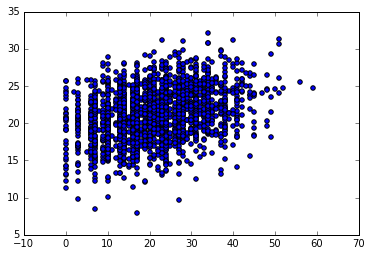

In [1572]:
predictions = cross_val_predict(regressor, X_train_away, y_train_away, cv=10)
plt.scatter(y_train_away, predictions)
plt.show()

In [1573]:
accuracy = metrics.r2_score(y_train_away, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.100097578153


In [1574]:
#Add column of ones to account for b_0
X_train_away = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_away, axis = 1)
X_train_away[1]

array([  1.        ,  -0.485     ,  51.5       ,   0.        ,
        -0.177     ,   1.        ,  -0.3       ,  68.1       ,
        24.94285714,  -4.34285714,  -0.551     ,   2.28571429,
        11.15714286,  41.71428571])

In [1575]:
X_opt = X_train_away[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     20.90
Date:                Fri, 10 May 2019   Prob (F-statistic):           2.71e-47
Time:                        08:12:07   Log-Likelihood:                -8016.8
No. Observations:                2188   AIC:                         1.606e+04
Df Residuals:                    2174   BIC:                         1.614e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0366      4.480      1.124      0.261      -3.749      13.822
x1             1.6972      1.096      1.549      0.122      -0.452       3.846
x2             0.2710      0.064      4.205      0.000       0.145       0.397
x3            -0.0631      0.530     -0.119      0.905      -1.103       0.977
x4            -1.2918      4.128     -0.313      0.754      -9.388       6.804
x5            -0.3290      0.464     -0.709      0.478      -1.239       0.581
x6             0.0392      0.043      0.904      0.366      -0.046       0.124
x7            -0.0017      0.068     -0.025      0.980      -0.134       0.131
x8            -0.0473      0.032     -1.468      0.142      -0.111       0.016
x9             0.0306      0.062      0.493      0.622      -0.091       0.153
x10            5.8549      1.003      5.839      0.000       3.888       7.821
x11            0.0793      0.049      1.635      0.102      -0.016       0.175
x12           -0.0402      0.080     -0.504      0.614      -0.197       0.116
x13            0.1059      0.053      2.014      0.044       0.003       0.209
==============================================================================
Omnibus:                       18.686   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.060
Skew:                           0.224   Prob(JB):                     7.26e-05
Kurtosis:                       2.911   Cond. No.                     2.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1576]:
X_opt = X_train_away[:, [0,1,2,3,5,6,7,8,9,10,11,12,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     22.64
Date:                Fri, 10 May 2019   Prob (F-statistic):           5.82e-48
Time:                        08:12:08   Log-Likelihood:                -8016.9
No. Observations:                2188   AIC:                         1.606e+04
Df Residuals:                    2175   BIC:                         1.613e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0106      4.478      1.119      0.263      -3.771      13.793
x1             1.6844      1.095      1.539      0.124      -0.463       3.831
x2             0.2722      0.064      4.231      0.000       0.146       0.398
x3            -0.0622      0.530     -0.117      0.907      -1.102       0.977
x4            -0.3283      0.464     -0.707      0.479      -1.238       0.582
x5             0.0392      0.043      0.904      0.366      -0.046       0.124
x6            -0.0011      0.067     -0.017      0.987      -0.133       0.131
x7            -0.0475      0.032     -1.474      0.141      -0.111       0.016
x8             0.0325      0.062      0.525      0.600      -0.089       0.154
x9             5.8046      0.990      5.866      0.000       3.864       7.745
x10            0.0795      0.049      1.640      0.101      -0.016       0.175
x11           -0.0396      0.080     -0.496      0.620      -0.196       0.117
x12            0.1044      0.052      1.994      0.046       0.002       0.207
==============================================================================
Omnibus:                       18.769   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.147
Skew:                           0.225   Prob(JB):                     6.96e-05
Kurtosis:                       2.911   Cond. No.                     2.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1577]:
X_opt = X_train_away[:, [0,1,2,3,5,6,7,8,9,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     24.68
Date:                Fri, 10 May 2019   Prob (F-statistic):           1.28e-48
Time:                        08:12:09   Log-Likelihood:                -8017.0
No. Observations:                2188   AIC:                         1.606e+04
Df Residuals:                    2176   BIC:                         1.613e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5880      4.324      1.292      0.196      -2.891      14.067
x1             1.7464      1.088      1.606      0.108      -0.386       3.879
x2             0.2728      0.064      4.241      0.000       0.147       0.399
x3            -0.0493      0.529     -0.093      0.926      -1.087       0.989
x4            -0.3268      0.464     -0.704      0.481      -1.237       0.583
x5             0.0238      0.030      0.785      0.432      -0.036       0.083
x6            -0.0109      0.065     -0.169      0.866      -0.137       0.116
x7            -0.0556      0.028     -2.004      0.045      -0.110      -0.001
x8             0.0264      0.061      0.435      0.663      -0.092       0.145
x9             5.8491      0.985      5.936      0.000       3.917       7.781
x10            0.0626      0.034      1.819      0.069      -0.005       0.130
x11            0.1024      0.052      1.962      0.050    6.37e-05       0.205
==============================================================================
Omnibus:                       18.813   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.191
Skew:                           0.225   Prob(JB):                     6.80e-05
Kurtosis:                       2.910   Cond. No.                     1.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1578]:
X_opt = X_train_away[:, [0,1,2,3,6,7,8,9,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     27.11
Date:                Fri, 10 May 2019   Prob (F-statistic):           3.04e-49
Time:                        08:12:09   Log-Likelihood:                -8017.2
No. Observations:                2188   AIC:                         1.606e+04
Df Residuals:                    2177   BIC:                         1.612e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5317      4.322      1.280      0.201      -2.945      14.008
x1             1.7640      1.087      1.623      0.105      -0.368       3.896
x2             0.2703      0.064      4.209      0.000       0.144       0.396
x3             0.1136      0.476      0.239      0.811      -0.820       1.047
x4             0.0267      0.030      0.887      0.375      -0.032       0.086
x5            -0.0128      0.064     -0.198      0.843      -0.139       0.114
x6            -0.0564      0.028     -2.035      0.042      -0.111      -0.002
x7             0.0273      0.061      0.451      0.652      -0.092       0.146
x8             5.8335      0.985      5.922      0.000       3.902       7.765
x9             0.0632      0.034      1.839      0.066      -0.004       0.131
x10            0.1035      0.052      1.984      0.047       0.001       0.206
==============================================================================
Omnibus:                       18.645   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.018
Skew:                           0.224   Prob(JB):                     7.42e-05
Kurtosis:                       2.911   Cond. No.                     1.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1579]:
X_opt = X_train_away[:, [0,1,2,6,7,8,9,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     30.13
Date:                Fri, 10 May 2019   Prob (F-statistic):           5.52e-50
Time:                        08:12:10   Log-Likelihood:                -8017.3
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2178   BIC:                         1.611e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6803      4.276      1.328      0.184      -2.706      14.067
x1             1.7914      1.081      1.657      0.098      -0.328       3.911
x2             0.2669      0.063      4.263      0.000       0.144       0.390
x3             0.0263      0.030      0.876      0.381      -0.033       0.085
x4            -0.0123      0.064     -0.191      0.848      -0.139       0.114
x5            -0.0560      0.028     -2.024      0.043      -0.110      -0.002
x6             0.0274      0.061      0.451      0.652      -0.091       0.146
x7             5.8014      0.976      5.947      0.000       3.888       7.715
x8             0.0633      0.034      1.843      0.065      -0.004       0.131
x9             0.1046      0.052      2.014      0.044       0.003       0.206
==============================================================================
Omnibus:                       18.608   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.981
Skew:                           0.224   Prob(JB):                     7.56e-05
Kurtosis:                       2.912   Cond. No.                     1.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1580]:
X_opt = X_train_away[:, [0,1,2,7,8,9,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     33.80
Date:                Fri, 10 May 2019   Prob (F-statistic):           1.33e-50
Time:                        08:12:10   Log-Likelihood:                -8017.6
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2179   BIC:                         1.610e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5288      4.273      1.294      0.196      -2.850      13.908
x1             1.7226      1.078      1.598      0.110      -0.391       3.836
x2             0.2790      0.061      4.569      0.000       0.159       0.399
x3            -0.0211      0.064     -0.332      0.740      -0.146       0.104
x4            -0.0598      0.027     -2.192      0.028      -0.113      -0.006
x5             0.0432      0.058      0.748      0.455      -0.070       0.157
x6             5.7890      0.975      5.935      0.000       3.876       7.702
x7             0.0591      0.034      1.737      0.083      -0.008       0.126
x8             0.1076      0.052      2.075      0.038       0.006       0.209
==============================================================================
Omnibus:                       18.565   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.933
Skew:                           0.223   Prob(JB):                     7.74e-05
Kurtosis:                       2.910   Cond. No.                     1.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1581]:
X_opt = X_train_away[:, [0,1,2,7,8,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     38.56
Date:                Fri, 10 May 2019   Prob (F-statistic):           2.71e-51
Time:                        08:12:11   Log-Likelihood:                -8017.9
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2180   BIC:                         1.610e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1425      4.241      1.213      0.225      -3.174      13.459
x1             1.7190      1.078      1.595      0.111      -0.394       3.833
x2             0.2616      0.056      4.635      0.000       0.151       0.372
x3            -0.0121      0.062     -0.193      0.847      -0.135       0.110
x4            -0.0551      0.027     -2.075      0.038      -0.107      -0.003
x5             6.0712      0.899      6.750      0.000       4.307       7.835
x6             0.0684      0.032      2.162      0.031       0.006       0.130
x7             0.1186      0.050      2.386      0.017       0.021       0.216
==============================================================================
Omnibus:                       18.484   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.846
Skew:                           0.223   Prob(JB):                     8.09e-05
Kurtosis:                       2.909   Cond. No.                     1.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1582]:
X_opt = X_train_away[:, [0,1,2,8,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     45.00
Date:                Fri, 10 May 2019   Prob (F-statistic):           3.94e-52
Time:                        08:12:11   Log-Likelihood:                -8017.9
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2181   BIC:                         1.609e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4607      2.354      1.895      0.058      -0.155       9.076
x1             1.6342      0.984      1.661      0.097      -0.296       3.564
x2             0.2603      0.056      4.646      0.000       0.150       0.370
x3            -0.0550      0.027     -2.073      0.038      -0.107      -0.003
x4             6.0661      0.899      6.749      0.000       4.303       7.829
x5             0.0668      0.030      2.191      0.029       0.007       0.127
x6             0.1172      0.049      2.383      0.017       0.021       0.214
==============================================================================
Omnibus:                       18.485   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.850
Skew:                           0.223   Prob(JB):                     8.07e-05
Kurtosis:                       2.910   Cond. No.                         748.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1583]:
X_opt = X_train_away[:, [0,1,2,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     53.06
Date:                Fri, 10 May 2019   Prob (F-statistic):           4.24e-52
Time:                        08:12:11   Log-Likelihood:                -8020.1
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2182   BIC:                         1.609e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5434      2.355      1.929      0.054      -0.075       9.162
x1             1.5896      0.985      1.614      0.107      -0.341       3.521
x2             0.2562      0.056      4.573      0.000       0.146       0.366
x3             5.8829      0.895      6.572      0.000       4.127       7.638
x4             0.0714      0.030      2.347      0.019       0.012       0.131
x5             0.1103      0.049      2.246      0.025       0.014       0.207
==============================================================================
Omnibus:                       18.755   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.130
Skew:                           0.225   Prob(JB):                     7.02e-05
Kurtosis:                       2.910   Cond. No.                         743.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1584]:
X_opt = X_train_away[:, [0,2,10,11,13]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     65.62
Date:                Fri, 10 May 2019   Prob (F-statistic):           1.78e-52
Time:                        08:12:12   Log-Likelihood:                -8021.4
No. Observations:                2188   AIC:                         1.605e+04
Df Residuals:                    2183   BIC:                         1.608e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2002      2.346      1.790      0.074      -0.401       8.802
x1             0.2664      0.056      4.782      0.000       0.157       0.376
x2             6.0455      0.890      6.794      0.000       4.301       7.790
x3             0.0764      0.030      2.524      0.012       0.017       0.136
x4             0.1077      0.049      2.194      0.028       0.011       0.204
==============================================================================
Omnibus:                       19.137   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.534
Skew:                           0.227   Prob(JB):                     5.73e-05
Kurtosis:                       2.913   Cond. No.                         740.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1585]:
# Optimal model using alpha < 0.1 significance level ^
X_test_away.shape

(548, 13)

In [1586]:
# Now use this model to make predictions on the test set
X_test_away = np.append(arr = np.ones((548,1)).astype(int), values = X_test_away, axis = 1)
X_test_away = X_test_away[:, [0,2,10,11,13]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_away)
y_pred_away = regressor.predict(X_test_away)

In [1587]:
print(mean_squared_error(y_test_away, y_pred_away))

81.410640522


In [1503]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,random_state=1641)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_home.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

In [1504]:
X_train_home.head()

,offDvoaMatchup,overUnder,roof,stDvoa,surface,runMatchup,avgRecv,pblkMatchup,ovrMatchup,totalDvoaMatchup,passMatchup,offMatchup,ptsMatchup
917,0.041,43.5,1,-0.002,0,2.542857,64.728571,2.671429,-6.471429,-0.154,8.600000,2.457143,42.000000
1922,-0.257,51.5,0,0.067,1,4.400000,73.728571,7.028571,4.342857,0.551,14.557143,12.742857,59.428571
327,-0.100,46.0,1,0.032,0,-5.485714,65.200000,8.371429,3.571429,0.471,-2.028571,0.728571,51.857143
2777,0.105,43.5,0,0.034,1,-16.071429,66.571429,5.214286,-9.842857,-0.516,-1.957143,-6.500000,38.857143
1045,-0.054,41.0,1,0.056,1,-4.428571,62.928571,9.814286,2.285714,-0.058,-6.685714,6.757143,44.285714


In [1505]:
regressor = LinearRegression()
regressor.fit(X_train_home, y_train_home)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1506]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_home, y_train_home, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.15783647  0.15087117  0.18820819  0.13214235  0.07794093  0.19970198
  0.07602654  0.05225611  0.13998145  0.1118125 ]


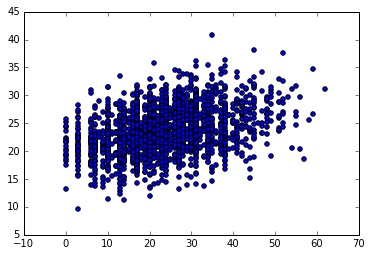

In [1507]:
predictions = cross_val_predict(regressor, X_train_home, y_train_home, cv=10)
plt.scatter(y_train_home, predictions)
plt.show()

In [1508]:
accuracy = metrics.r2_score(y_train_home, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.13013093167


In [1509]:
X_train_home.shape

(2188, 13)

In [1510]:
#Add column of ones to account for b_0
X_train_home = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_home, axis = 1)
X_train_home[1]

array([  1.00000000e+00,  -2.57000000e-01,   5.15000000e+01,
         0.00000000e+00,   6.70000000e-02,   1.00000000e+00,
         4.40000000e+00,   7.37285714e+01,   7.02857143e+00,
         4.34285714e+00,   5.51000000e-01,   1.45571429e+01,
         1.27428571e+01,   5.94285714e+01])

In [1511]:
X_opt = X_train_home[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     27.01
Date:                Mon, 06 May 2019   Prob (F-statistic):           7.28e-62
Time:                        17:12:02   Log-Likelihood:                -8127.3
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2174   BIC:                         1.636e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1124      4.830      2.301      0.022       1.641      20.584
x1             5.0358      1.143      4.405      0.000       2.794       7.278
x2             0.4589      0.066      6.940      0.000       0.329       0.589
x3            -0.5846      0.553     -1.058      0.290      -1.669       0.499
x4            10.3869      4.364      2.380      0.017       1.829      18.945
x5             0.9563      0.493      1.942      0.052      -0.010       1.922
x6            -0.0535      0.044     -1.205      0.228      -0.141       0.034
x7            -0.1288      0.071     -1.804      0.071      -0.269       0.011
x8             0.0028      0.034      0.082      0.935      -0.064       0.070
x9             0.1119      0.066      1.691      0.091      -0.018       0.242
x10            6.7978      1.047      6.491      0.000       4.744       8.852
x11           -0.0161      0.050     -0.322      0.748      -0.114       0.082
x12            0.0937      0.084      1.119      0.263      -0.070       0.258
x13            0.0076      0.055      0.139      0.890      -0.100       0.115
==============================================================================
Omnibus:                       34.380   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.598
Skew:                           0.307   Prob(JB):                     1.86e-08
Kurtosis:                       3.120   Cond. No.                     2.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1512]:
X_opt = X_train_home[:, [0,1,2,3,4,6,7,8,9,10,11,12,13]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     28.91
Date:                Mon, 06 May 2019   Prob (F-statistic):           8.20e-62
Time:                        17:12:02   Log-Likelihood:                -8129.2
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2175   BIC:                         1.636e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9369      4.814      2.479      0.013       2.496      21.378
x1             5.2230      1.140      4.582      0.000       2.988       7.458
x2             0.4658      0.066      7.050      0.000       0.336       0.595
x3            -1.0559      0.497     -2.125      0.034      -2.030      -0.082
x4            11.6415      4.319      2.696      0.007       3.172      20.111
x5            -0.0520      0.044     -1.172      0.241      -0.139       0.035
x6            -0.1324      0.071     -1.853      0.064      -0.272       0.008
x7             0.0073      0.034      0.215      0.830      -0.059       0.074
x8             0.1258      0.066      1.911      0.056      -0.003       0.255
x9             6.7209      1.047      6.418      0.000       4.667       8.775
x10           -0.0133      0.050     -0.265      0.791      -0.112       0.085
x11            0.0836      0.084      1.000      0.317      -0.080       0.248
x12            0.0047      0.055      0.086      0.932      -0.103       0.112
==============================================================================
Omnibus:                       33.872   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.046
Skew:                           0.305   Prob(JB):                     2.45e-08
Kurtosis:                       3.116   Cond. No.                     2.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1513]:
X_opt = X_train_home[:, [0,1,2,3,4,6,7,8,9,10,12,13]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     31.55
Date:                Mon, 06 May 2019   Prob (F-statistic):           1.47e-62
Time:                        17:12:03   Log-Likelihood:                -8129.3
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2176   BIC:                         1.635e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0395      4.798      2.509      0.012       2.631      21.448
x1             5.2001      1.136      4.577      0.000       2.972       7.428
x2             0.4631      0.065      7.095      0.000       0.335       0.591
x3            -1.0603      0.497     -2.135      0.033      -2.034      -0.087
x4            11.6430      4.318      2.697      0.007       3.176      20.110
x5            -0.0452      0.036     -1.250      0.211      -0.116       0.026
x6            -0.1305      0.071     -1.836      0.067      -0.270       0.009
x7             0.0112      0.031      0.367      0.713      -0.049       0.071
x8             0.1237      0.065      1.893      0.058      -0.004       0.252
x9             6.7094      1.046      6.414      0.000       4.658       8.761
x10            0.0680      0.059      1.147      0.251      -0.048       0.184
x11            0.0031      0.055      0.056      0.955      -0.104       0.110
==============================================================================
Omnibus:                       33.786   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.954
Skew:                           0.304   Prob(JB):                     2.57e-08
Kurtosis:                       3.117   Cond. No.                     2.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1514]:
X_opt = X_train_home[:, [0,1,2,3,4,6,7,8,9,10,12]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     34.72
Date:                Mon, 06 May 2019   Prob (F-statistic):           2.43e-63
Time:                        17:12:03   Log-Likelihood:                -8129.3
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2177   BIC:                         1.634e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0843      4.731      2.555      0.011       2.807      21.361
x1             5.1970      1.135      4.580      0.000       2.972       7.422
x2             0.4649      0.057      8.200      0.000       0.354       0.576
x3            -1.0577      0.494     -2.140      0.032      -2.027      -0.088
x4            11.6615      4.304      2.709      0.007       3.220      20.103
x5            -0.0454      0.036     -1.260      0.208      -0.116       0.025
x6            -0.1303      0.071     -1.836      0.067      -0.270       0.009
x7             0.0111      0.030      0.364      0.716      -0.049       0.071
x8             0.1247      0.063      1.982      0.048       0.001       0.248
x9             6.7288      0.988      6.814      0.000       4.792       8.665
x10            0.0687      0.058      1.180      0.238      -0.045       0.183
==============================================================================
Omnibus:                       33.857   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.031
Skew:                           0.304   Prob(JB):                     2.47e-08
Kurtosis:                       3.117   Cond. No.                     1.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1515]:
X_opt = X_train_home[:, [0,1,2,3,4,6,7,9,10,12]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     38.58
Date:                Mon, 06 May 2019   Prob (F-statistic):           4.05e-64
Time:                        17:12:04   Log-Likelihood:                -8129.3
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2178   BIC:                         1.634e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3924      4.653      2.663      0.008       3.267      21.517
x1             5.2139      1.134      4.600      0.000       2.991       7.437
x2             0.4660      0.057      8.234      0.000       0.355       0.577
x3            -1.0454      0.493     -2.120      0.034      -2.012      -0.079
x4            11.6845      4.303      2.715      0.007       3.246      20.123
x5            -0.0491      0.035     -1.418      0.156      -0.117       0.019
x6            -0.1353      0.070     -1.942      0.052      -0.272       0.001
x7             0.1259      0.063      2.004      0.045       0.003       0.249
x8             6.7268      0.987      6.813      0.000       4.791       8.663
x9             0.0750      0.055      1.353      0.176      -0.034       0.184
==============================================================================
Omnibus:                       33.854   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.027
Skew:                           0.304   Prob(JB):                     2.48e-08
Kurtosis:                       3.117   Cond. No.                     1.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1516]:
X_opt = X_train_home[:, [0,1,2,3,4,7,9,10,12]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     43.13
Date:                Mon, 06 May 2019   Prob (F-statistic):           1.60e-64
Time:                        17:12:04   Log-Likelihood:                -8130.3
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2179   BIC:                         1.633e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0654      4.559      2.427      0.015       2.125      20.006
x1             5.2892      1.133      4.670      0.000       3.068       7.510
x2             0.4631      0.057      8.185      0.000       0.352       0.574
x3            -1.0219      0.493     -2.074      0.038      -1.988      -0.055
x4            11.5225      4.303      2.678      0.007       3.085      19.960
x5            -0.1082      0.067     -1.615      0.107      -0.240       0.023
x6             0.1273      0.063      2.026      0.043       0.004       0.250
x7             6.7621      0.987      6.850      0.000       4.826       8.698
x8             0.0355      0.048      0.740      0.460      -0.059       0.129
==============================================================================
Omnibus:                       32.916   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.013
Skew:                           0.301   Prob(JB):                     4.11e-08
Kurtosis:                       3.108   Cond. No.                     1.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1517]:
X_opt = X_train_home[:, [0,1,2,3,4,7,9,10]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     49.22
Date:                Mon, 06 May 2019   Prob (F-statistic):           2.86e-65
Time:                        17:12:05   Log-Likelihood:                -8130.6
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2180   BIC:                         1.632e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8762      4.266      2.315      0.021       1.511      18.242
x1             5.1785      1.123      4.613      0.000       2.977       7.380
x2             0.4795      0.052      9.214      0.000       0.377       0.582
x3            -1.0143      0.493     -2.059      0.040      -1.980      -0.048
x4            11.4553      4.301      2.663      0.008       3.021      19.890
x5            -0.0992      0.066     -1.505      0.132      -0.228       0.030
x6             0.1539      0.052      2.988      0.003       0.053       0.255
x7             6.7521      0.987      6.841      0.000       4.817       8.688
==============================================================================
Omnibus:                       33.612   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.767
Skew:                           0.304   Prob(JB):                     2.82e-08
Kurtosis:                       3.107   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1518]:
X_opt = X_train_home[:, [0,1,2,3,4,9,10]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     57.01
Date:                Mon, 06 May 2019   Prob (F-statistic):           1.11e-65
Time:                        17:12:05   Log-Likelihood:                -8131.7
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2181   BIC:                         1.632e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4433      2.274      1.954      0.051      -0.016       8.903
x1             4.4918      1.026      4.378      0.000       2.480       6.504
x2             0.4523      0.049      9.265      0.000       0.357       0.548
x3            -0.9941      0.493     -2.018      0.044      -1.960      -0.028
x4            11.7833      4.297      2.742      0.006       3.357      20.210
x5             0.1278      0.049      2.634      0.009       0.033       0.223
x6             6.7089      0.987      6.798      0.000       4.774       8.644
==============================================================================
Omnibus:                       34.418   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.638
Skew:                           0.307   Prob(JB):                     1.82e-08
Kurtosis:                       3.119   Cond. No.                         901.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1519]:
X_opt = X_train_home[:, [0,1,2,4,9,10]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     67.51
Date:                Mon, 06 May 2019   Prob (F-statistic):           9.54e-66
Time:                        17:12:06   Log-Likelihood:                -8133.8
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2182   BIC:                         1.631e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8610      2.136      1.339      0.181      -1.328       7.050
x1             4.5353      1.026      4.419      0.000       2.522       6.548
x2             0.4716      0.048      9.843      0.000       0.378       0.566
x3            11.5105      4.298      2.678      0.007       3.082      19.939
x4             0.1347      0.048      2.782      0.005       0.040       0.230
x5             6.5159      0.983      6.629      0.000       4.588       8.444
==============================================================================
Omnibus:                       33.630   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.786
Skew:                           0.303   Prob(JB):                     2.79e-08
Kurtosis:                       3.119   Cond. No.                         901.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1520]:
X_opt = X_train_home[:, [0,1,2,9,10]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     82.36
Date:                Mon, 06 May 2019   Prob (F-statistic):           3.42e-65
Time:                        17:12:07   Log-Likelihood:                -8137.4
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2183   BIC:                         1.631e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9349      2.139      1.372      0.170      -1.259       7.129
x1             4.6733      1.027      4.552      0.000       2.660       6.686
x2             0.4700      0.048      9.797      0.000       0.376       0.564
x3             0.1209      0.048      2.507      0.012       0.026       0.215
x4             7.0032      0.967      7.240      0.000       5.106       8.900
==============================================================================
Omnibus:                       34.596   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.832
Skew:                           0.308   Prob(JB):                     1.66e-08
Kurtosis:                       3.113   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1521]:
X_test_home.shape

(548, 13)

In [1522]:
# Now use this model to make predictions on the test set
X_test_home = np.append(arr = np.ones((548,1)).astype(int), values = X_test_home, axis = 1)
X_test_home = X_test_home[:, [0,1,2,9,10]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_home)
y_pred_home = regressor.predict(X_test_home)

In [1523]:
y_test_away

,pf
495,24
1735,15
3114,26
1771,27
485,20
2927,16
129,14
162,37
2877,10
2991,47


In [1524]:
y_test_away = y_test_away.reset_index()
y_test_away = y_test_away[['pf']]
y_test_home = y_test_home.reset_index()
y_test_home = y_test_home[['pf']]

In [1525]:
y_test_away

,pf
0,24
1,15
2,26
3,27
4,20
5,16
6,14
7,37
8,10
9,47


In [1526]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [1527]:
testDf = testDf.rename(index=int, columns = {1:'overUnder',2:'totalDvoaMatchup',3:'passMatchup',4:'ptsMatchup'})
testDf = testDf.drop(0,axis=1)
testDf

,overUnder,totalDvoaMatchup,passMatchup,ptsMatchup,awayScore,awayPrediction
0,48.5,0.155,18.500000,53.571429,24,25.238670
1,45.0,-0.398,-3.757143,40.285714,15,17.831996
2,47.0,-0.189,14.628571,41.285714,26,21.140494
3,47.0,0.177,5.557143,46.285714,27,23.198646
4,48.0,0.475,22.242857,59.142857,20,27.926055
5,44.0,0.495,24.314286,46.714286,16,25.801164
6,44.0,-0.360,10.071429,43.000000,14,19.144158
7,52.5,0.436,-3.128571,43.714286,37,25.288849
8,45.5,-0.379,0.771429,40.857143,10,18.487545
9,44.0,0.729,14.657143,50.571429,47,26.893477


In [1528]:
testDf2.head()

,0,1,2,3,4,homeScore,homePrediction
0,1.0,-0.419,48.5,-8.614286,-0.155,17,21.643709
1,1.0,0.174,45.0,3.142857,0.398,38,28.064063
2,1.0,0.285,47.0,-5.371429,0.189,24,27.029845
3,1.0,-0.041,47.0,0.100000,-0.177,13,23.604580
4,1.0,-0.311,48.0,-13.742857,-0.475,27,19.052455


In [1529]:
testDf2 = testDf2.rename(index=int, columns = {1:'offDvoaMatchup',2:'overUnder',3:'ovrMatchup',4:'totalDvoaMatchup'})
testDf2 = testDf2.drop(0,axis=1)
testDf2

,offDvoaMatchup,overUnder,ovrMatchup,totalDvoaMatchup,homeScore,homePrediction
0,-0.419,48.5,-8.614286,-0.155,17,21.643709
1,0.174,45.0,3.142857,0.398,38,28.064063
2,0.285,47.0,-5.371429,0.189,24,27.029845
3,-0.041,47.0,0.100000,-0.177,13,23.604580
4,-0.311,48.0,-13.742857,-0.475,27,19.052455
5,0.004,44.0,-6.571429,-0.495,23,19.371478
6,-0.030,44.0,4.142857,0.360,35,26.495501
7,0.074,52.5,1.657143,-0.436,36,25.101258
8,0.062,45.5,6.414286,0.379,19,28.038039
9,-0.001,44.0,-11.371429,-0.729,10,17.129125


In [1530]:
colsAway = list(testDf.columns)
colsAway.pop(-1)
colsAway.pop(-1)
#colsAway
colsHome = list(testDf2.columns)
colsHome.pop(-1)
colsHome.pop(-1)
# colsHome.pop(2)
#colsHome
# cols.pop(7)
# cols.pop(7)

'homeScore'

In [1531]:
awayPredDf = awayMatchup.merge(testDf, on=colsAway)
homePredDf = homeMatchup.merge(testDf2, on=colsHome)

In [1532]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
#awayHomeMerge.columns

In [1533]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201611270atl,2016-11-27,2016,12,21.384741,29.605186
1,201612110mia,2016-12-11,2016,14,20.830092,24.546859
2,201711050sfo,2017-11-05,2017,9,20.209151,19.865027
3,201610060sfo,2016-10-06,2016,5,20.484636,22.119856
4,201711050car,2017-11-05,2017,9,19.888701,21.159460


In [1534]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
#finalDf.columns

In [1535]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [1536]:
finalDf.head()

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,200901100car,2009-01-10,2008,19,Arizona Cardinals,21.619440,33,Carolina Panthers,30.428743,13,49.5,under,52.048183,46
1,200810260car,2008-10-26,2008,8,Arizona Cardinals,21.203696,23,Carolina Panthers,23.037793,27,43.0,over,44.241489,50
2,201212300sfo,2012-12-30,2012,17,Arizona Cardinals,14.393947,13,San Francisco 49ers,27.788495,27,39.5,over,42.182443,40
3,201411230sea,2014-11-23,2014,12,Arizona Cardinals,19.535076,3,Seattle Seahawks,24.583409,19,41.5,under,44.118485,22
4,200911220ram,2009-11-22,2009,11,Arizona Cardinals,27.552539,21,Los Angeles Rams,19.733660,13,47.0,under,47.286199,34


In [1537]:
finalDf[finalDf['season'] == 2018]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
24,201811040was,2018-11-04,2018,9,Atlanta Falcons,20.969832,38,Washington Redskins,24.716766,14,46.5,over,45.686598,52
27,201810070pit,2018-10-07,2018,5,Atlanta Falcons,25.618295,17,Pittsburgh Steelers,29.168240,41,57.0,over,54.786535,58
53,201812020atl,2018-12-02,2018,13,Baltimore Ravens,23.359906,26,Atlanta Falcons,24.110805,16,46.5,under,47.470711,42
75,201810140htx,2018-10-14,2018,6,Buffalo Bills,15.713857,13,Houston Texans,25.720194,20,40.5,under,41.434051,33
77,201812090cle,2018-12-09,2018,14,Carolina Panthers,23.920050,20,Cleveland Browns,23.183935,26,47.5,under,47.103985,46
92,201812020tam,2018-12-02,2018,13,Carolina Panthers,26.200366,17,Tampa Bay Buccaneers,25.006150,24,52.0,under,51.206516,41
115,201809230car,2018-09-23,2018,3,Cincinnati Bengals,22.836889,21,Carolina Panthers,23.129588,31,44.0,over,45.966477,52
124,201811180rav,2018-11-18,2018,11,Cincinnati Bengals,19.559513,21,Baltimore Ravens,25.289772,24,44.0,over,44.849285,45
126,201809300atl,2018-09-30,2018,4,Cincinnati Bengals,25.288849,37,Atlanta Falcons,25.101258,36,52.5,over,50.390107,73
135,201810280pit,2018-10-28,2018,8,Cleveland Browns,21.238634,18,Pittsburgh Steelers,28.623232,33,47.5,over,49.861866,51


In [1538]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 1]
undersDf['result'].value_counts()

over     36
under    27
Name: result, dtype: int64

In [1539]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf['result'].value_counts()

over     12
under     7
Name: result, dtype: int64

In [1454]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf[oversDf['season'] == 2011]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
34,201112040htx,2011-12-04,2011,13,Atlanta Falcons,17.343029,10,Houston Texans,23.942846,17,38.0,under,41.285875,27
163,201201010gnb,2012-01-01,2011,17,Detroit Lions,19.056737,41,Green Bay Packers,26.263065,45,42.0,over,45.319802,86
471,201110090nyg,2011-10-09,2011,5,Seattle Seahawks,19.076239,36,New York Giants,27.551895,25,43.5,over,46.628134,61


In [1358]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 1]
undersDf[undersDf['season'] == 2017]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
30,201710290nyj,2017-10-29,2017,8,Atlanta Falcons,22.622097,25,New York Jets,19.054932,20,43.5,over,41.677030,45
32,201712180tam,2017-12-18,2017,15,Atlanta Falcons,24.190097,24,Tampa Bay Buccaneers,23.754768,21,49.5,under,47.944865,45
138,201712030sdg,2017-12-03,2017,13,Cleveland Browns,15.689615,10,Los Angeles Chargers,28.290320,19,45.0,under,43.979936,29
152,201709250crd,2017-09-25,2017,3,Dallas Cowboys,22.257437,28,Arizona Cardinals,22.295138,17,46.5,under,44.552576,45
233,201710290cin,2017-10-29,2017,8,Indianapolis Colts,16.141938,23,Cincinnati Bengals,26.278491,24,44.0,over,42.420429,47
290,201709240nyj,2017-09-24,2017,3,Miami Dolphins,23.568010,6,New York Jets,18.033116,20,43.0,under,41.601126,26
323,201712030buf,2017-12-03,2017,13,New England Patriots,25.670716,23,Buffalo Bills,21.483090,3,48.5,under,47.153806,26
329,201710050tam,2017-10-05,2017,5,New England Patriots,24.593552,19,Tampa Bay Buccaneers,27.564048,14,54.5,under,52.157600,33
336,201709240car,2017-09-24,2017,3,New Orleans Saints,16.985915,34,Carolina Panthers,27.312256,13,46.5,over,44.298171,47
355,201710010mia,2017-10-01,2017,4,New Orleans Saints,27.520816,20,Miami Dolphins,22.341545,0,51.5,under,49.862361,20


In [3768]:
#USING 0 POINT OVERS DEFINITION
# rs - record - %
# 1229 - 184/134/8 - 57.9%
# 4375 - 185/176/5 - 51.3%
# 187 - 165/200/4 - 45.2%
# 333 - 172/199/6 - 46.4%
# 399 - 185/169/8 - 52.3%
# 472 - 179/168/9 - 51.6%
# 901 - 188/173/10 - 52.1%
# 2336 - 171/168/10 - 50.4%
# 403 - 195/171/4 - 53.3%
# 407 - 178/158/7 - 53.0%
# 511 - 182/157/5 - 53.7%
# 698 - 171/164/5 - 51.0%
# 222 - 153/155/5 - 49.7%
# 223 - 170/174/7 - 49.4%
# 657 - 176/168/2 - 51.2%

#USING 3 POINT OVERS DEFINITION
# rs - record - %
# 890 - 68/55/6 - 55.3%
# 0 - 62/48/3 - 56.4%
# 1 - 56/46/2 - 54.9%
# 122 - 77/64/2 - 54.6%
# 731 - 58/56/3 - 50.9%
# 556 - 69/46/4 - 60%
# 1229 - 75/43/4 - 63.6%
# 4375 - 78/59/3 - 56.9%
# 187 - 65/73/2 - 47.1%
# 333 - 75/76/3 - 49.7%
# 399 - 65/62/3 - 51.2%
# 472 - 66/50/5 - 56.9%
# 901 - 69/55/5 - 55.6%
# 2336 - 73/47/3 - 60.8%
# 403 - 81/45/2 - 64.3%
# 407 - 54/50/3 - 51.9%
# 511 - 75/57/2 - 56.8%
# 698 - 64/55/2 - 53.8%
# 222 - 44/53/3 - 45.4%
# 223 - 66/56/2 - 54.1%
# 657 - 60/47 - 56.1%


#USING 5 POINT OVERS DEFINITION
# rs - record - %
# 890 - 25/19/3 - 56.8%
# 0 - 30/14/1 - 68.2%
# 1 - 18/17/1 - 51.4%
# 122 - 36/20 - 64.3%
# 731 - 27/16 - 62.8%
# 556 - 27/13/2 - 67.5%%
# 1229 - 27/17/2 - 61.4%
# 4375 - 27/28 - 49.1%
# 187 - 26/20/1 - 56.5%
# 333 - 31/21/1 - 59.6%
# 399 - 21/24/1 - 46.7%
# 472 - 26/13/3 - 66.7%
# 901 - 23/19/1 - 54.8%
# 2336 - 33/19/3 - 63.5%
# 403 - 38/16 - 70.4%
# 407 - 24/23/2 - 51.1%
# 511 - 28/21 - 57.1%
# 698 - 20/16/1 - 55.6%
# 222 - 14/17/2 - 45.2%
# 223 - 26/21/1 - 55.3%
# 657 - 17/16 - 51.5%

In [3773]:
oversDf[oversDf['week'] == 1]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
4,201009120ram,2010-09-12,2010,1,Arizona Cardinals,22.389061,17,Los Angeles Rams,22.161775,13,39.5,under,44.550835,30
102,201209090tam,2012-09-09,2012,1,Carolina Panthers,26.918941,10,Tampa Bay Buccaneers,22.862580,16,45.5,under,49.781521,26
115,200809070clt,2008-09-07,2008,1,Chicago Bears,18.687336,29,Indianapolis Colts,28.687980,13,44.0,under,47.375316,42
143,201409070pit,2014-09-07,2014,1,Cleveland Browns,18.010455,27,Pittsburgh Steelers,28.322505,30,41.5,over,46.332960,57
144,201609110phi,2016-09-11,2016,1,Cleveland Browns,21.439432,10,Philadelphia Eagles,24.415808,29,41.5,under,45.855240,39
199,200709090buf,2007-09-09,2007,1,Denver Broncos,18.004482,15,Buffalo Bills,24.670617,14,37.0,under,42.675099,29
207,200809070atl,2008-09-07,2008,1,Detroit Lions,22.774539,21,Atlanta Falcons,22.931267,34,41.0,over,45.705806,55
331,200709090was,2007-09-09,2007,1,Miami Dolphins,17.871058,13,Washington Redskins,22.359050,16,34.5,under,40.230107,29
356,201609110oti,2016-09-11,2016,1,Minnesota Vikings,23.546006,25,Tennessee Titans,20.166286,16,40.0,over,43.712292,41
474,201409070nyj,2014-09-07,2014,1,Oakland Raiders,20.304851,14,New York Jets,26.212102,19,40.0,under,46.516953,33


In [3750]:
#USING 0 POINT UNDER DEFINITION
# rs - record - %
# 1229 - 157/138/3 - 53.2%
# 4375 - 137/116/5 - 54.2%
# 187 - 150/100/5 - 60%
# 333 - 124/118/5 - 51.2%
# 399 - 132/129/1 - 50.6%
# 472 - 141/125 - 53%
# 901 - 136/114/3 - 54.4%
# 2336 - 141/132/2 - 51.6%
# 403 - 141/111/2 - 55.9%
# 407 - 144/134/3 - 51.8%
# 511 - 134/144/2 - 48.2%
# 698 - 148/135/1 - 52.3%
# 222 - 149/158/4 - 48.5%
# 223 - 130/138/5 - 48.5%
# 657 - 141/135/2 - 51.1%

#USING 3 POINT UNDER DEFINITION
# rs - record - %
# 890 - 34/27/2 - 55.7%
# 0 - 60/35 - 63.2%
# 1 - 30/40/2 - 42.8%
# 122 - 40/37/1 - 52%
# 731 - 30/43/2 - 41.1%
# 556 - 39/32/2 - 54.9%
# 1229 - 45/44 - 50.6%
# 4375 - 43/29/1 - 59.7%
# 187 - 38/32/1 - 54.3%
# 333 - 33/24/2 - 57.9%
# 399 - 35/33 - 51.5%
# 472 - 39/35/1 - 52.7%
# 901 - 37/27/2 - 57.8%
# 2336 - 42/31/1 - 57.5%
# 403 - 42/27/1 - 60.9%
# 407 - 43/49/1 - 46.7%
# 511 - 41/49 - 45.6%
# 698 - 45/38 - 54.2%
# 222 - 45/49/1 - 47.9%
# 223 - 42/26/2 - 61.8%
# 657 - 45/30/1 - 60.0%

#USING 5 POINT UNDER DEFINITION
# rs - record - %
# 890 - 13/7 - 65%
# 0 - 17/9 - 65.4%
# 1 - 7/10/2 - 41.2%
# 122 - 15/10 - 60%
# 731 - 6/11/1 - 35.3%
# 556 - 14/6 - 70%
# 1229 - 15/12 - 55.6%
# 4375 - 11/6 - 64.7%
# 187 - 12/7 - 63.2%
# 333 - 9/5/1 - 64.3%
# 399 - 8/6 - 57.1%
# 472 - 8/6 - 57.1%
# 901 - 9/7 - 56.3%
# 2336 - 14/9 - 60.9%
# 403 - 13/4 - 56.4%
# 407 - 16/12 - 57.1%
# 511 - 13/17 - 43.3%
# 698 - 12/9 - 57.1%
# 222 - 15/21 - 41.7%
# 223 - 14/2/1 - 87.5%
# 657 - 13/9/1 - 59.1%

In [3752]:
undersDf[undersDf['season'] == 2017]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
35,201712240nor,2017-12-24,2017,16,Atlanta Falcons,20.295345,13,New Orleans Saints,27.289588,23,52.0,under,47.584933,36
321,201710010dal,2017-10-01,2017,4,Los Angeles Rams,20.933757,35,Dallas Cowboys,26.291936,30,51.0,over,47.225693,65
367,201712170pit,2017-12-17,2017,15,New England Patriots,23.193767,27,Pittsburgh Steelers,24.014447,24,52.5,under,47.208214,51
405,201712070atl,2017-12-07,2017,14,New Orleans Saints,23.150530,17,Atlanta Falcons,23.823302,20,51.5,under,46.973832,37
459,201712100kan,2017-12-10,2017,14,Oakland Raiders,20.952917,15,Kansas City Chiefs,23.252191,26,48.5,under,44.205108,41
479,201710010den,2017-10-01,2017,4,Oakland Raiders,19.419503,10,Denver Broncos,21.408810,16,44.0,under,40.828313,26


In [3753]:
g50Df = finalDf[finalDf['homePrediction'] > 30]

In [3754]:
g50Df

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,200901100car,2009-01-10,2008,19,Arizona Cardinals,21.456114,33,Carolina Panthers,30.109499,13,49.5,under,51.565614,46
13,201209160nwe,2012-09-16,2012,2,Arizona Cardinals,14.661796,20,New England Patriots,33.036047,18,47.0,under,47.697843,38
41,201812090kan,2018-12-09,2018,14,Baltimore Ravens,20.335024,24,Kansas City Chiefs,30.268742,27,48.5,over,50.603766,51
47,201301200nwe,2013-01-20,2012,20,Baltimore Ravens,18.863207,28,New England Patriots,30.841332,13,51.5,under,49.704539,41
69,201201010nwe,2012-01-01,2011,17,Buffalo Bills,17.713905,21,New England Patriots,31.585109,49,50.0,over,49.299014,70
86,200909200atl,2009-09-20,2009,2,Carolina Panthers,12.812757,20,Atlanta Falcons,32.541510,28,43.5,over,45.354266,48
87,201209300atl,2012-09-30,2012,4,Carolina Panthers,17.782448,28,Atlanta Falcons,30.437891,30,48.0,over,48.220339,58
95,201201010nor,2012-01-01,2011,17,Carolina Panthers,21.116914,17,New Orleans Saints,30.822088,45,55.0,over,51.939002,62
139,201312080nwe,2013-12-08,2013,14,Cleveland Browns,17.978222,26,New England Patriots,31.168725,27,47.5,over,49.146947,53
140,200710070nwe,2007-10-07,2007,5,Cleveland Browns,13.381684,17,New England Patriots,33.741859,34,48.0,over,47.123543,51


In [384]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,randyyom_state=890)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

In [385]:
rf = RandomForestRegressor(n_estimators=1000, randoyym_state=0)
rf.fit(X_train_home, y_train_home)
y_pred_home = rf.predict(X_test_home)

print(mean_squared_error(y_test_home, y_pred_home))

C:\Python34\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


47.9000733077


In [386]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
#testDf.columns

In [387]:
testDf.head()

,ptsMatchup,stDvoa,totalScore,totalDvoaMatchup,pblkMatchup,offMatchup,avgPa,roof,surface,offDvoaMatchup,runMatchup,ovrMatchup,passMatchup,awayScore,awayPrediction
2626,57.714286,-0.011,30,0.663,10.628571,18.357143,33.714286,1,0,0.078,-1.642857,13.257143,23.485714,24,18.015
585,42.142857,0.014,51,0.333,5.100000,-2.471429,21.714286,1,0,0.071,-8.557143,1.271429,3.414286,27,24.324
554,39.000000,-0.070,34,-0.271,6.271429,-1.571429,13.857143,0,1,0.316,-9.885714,-7.957143,-0.671429,10,14.340
2121,46.857143,0.006,42,0.105,7.885714,17.685714,17.428571,1,0,0.350,2.285714,5.942857,19.928571,17,21.043
219,38.428571,-0.022,43,-0.055,-6.742857,-3.214286,19.571429,1,0,-0.072,-6.714286,-2.914286,-10.442857,10,19.444


In [388]:
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [389]:
testDf2.head()

,ptsMatchup,stDvoa,totalScore,totalDvoaMatchup,pblkMatchup,offMatchup,avgPa,roof,surface,offDvoaMatchup,runMatchup,ovrMatchup,passMatchup,homeScore,homePrediction
2626,35.571429,-0.010,30,-0.663,12.842857,1.628571,22.714286,1,0,-0.713,1.185714,-13.257143,-4.200000,6,9.912
585,38.000000,0.002,51,-0.333,5.485714,-4.428571,24.857143,1,0,-0.448,-6.257143,-1.271429,-1.100000,24,23.761
554,55.285714,0.049,34,0.271,1.900000,13.957143,29.571429,0,1,-0.117,0.428571,7.957143,13.528571,24,21.440
2121,44.857143,0.015,42,-0.105,3.057143,10.014286,23.285714,1,0,-0.037,-4.757143,-5.942857,7.628571,25,21.346
219,42.000000,0.066,43,0.055,12.400000,-0.328571,20.142857,1,0,0.194,-6.800000,2.914286,-3.285714,33,24.045


In [390]:
awayMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa',
       'ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
       'runMatchup', 'offDvoaMatchup', 'totalDvoaMatchup', 'pf'],
      dtype='object')

In [391]:
cols = list(testDf.columns)
cols.pop(-1)
cols.pop(-1)
cols.pop(7)
cols.pop(7)
#cols

'surface'

In [392]:
awayPredDf = awayMatchup.merge(testDf, on=cols)
homePredDf = homeMatchup.merge(testDf2, on=cols)

In [393]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
awayHomeMerge.columns

Index(['gameId', 'date', 'season', 'week', 'team_x_x', 'homeAway_x',
       'stadium_x', 'roof_x_x', 'surface_x_x', 'avgPf_x', 'avgOvr_x_x',
       'avgOff_x', 'avgPass_x', 'avgPblk_x', 'avgRecv_x', 'avgRun_x',
       'avgRblk_x', 'totalDvoa_x_x', 'offDvoa_x', 'stDvoa_x', 'overUnder_x',
       'pf_x', 'totalScore_x', 'team_y_x', 'avgPa_x', 'avgOvr_y_x', 'avgDef_x',
       'avgRdef_x', 'avgPrsh_x', 'avgCov_x', 'totalDvoa_y_x', 'defDvoa_x',
       'ptsMatchup_x', 'offMatchup_x', 'ovrMatchup_x', 'passMatchup_x',
       'pblkMatchup_x', 'runMatchup_x', 'offDvoaMatchup_x',
       'totalDvoaMatchup_x', 'pf_x', 'roof_y_x', 'surface_y_x', 'awayScore',
       'awayPrediction', 'team_x_y', 'homeAway_y', 'stadium_y', 'roof_x_y',
       'surface_x_y', 'avgPf_y', 'avgOvr_x_y', 'avgOff_y', 'avgPass_y',
       'avgPblk_y', 'avgRecv_y', 'avgRun_y', 'avgRblk_y', 'totalDvoa_x_y',
       'offDvoa_y', 'stDvoa_y', 'overUnder_y', 'pf_y', 'totalScore_y',
       'team_y_y', 'avgPa_y', 'avgOvr_y_y', 'avgDef_y'

In [394]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201811110kan,2018-11-11,2018,10,10.421,25.985
1,201612240sea,2016-12-24,2016,16,28.892,35.930
2,201712170was,2017-12-17,2017,15,15.474,19.271
3,201810070sfo,2018-10-07,2018,5,20.159,25.452
4,201709170clt,2017-09-17,2017,2,17.987,17.019


In [395]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
finalDf.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week',
       'awayPrediction', 'homePrediction', 'totalPrediction'],
      dtype='object')

In [396]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [397]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder']]

In [398]:
oversDf['result'].value_counts()

over     274
push      12
under     10
Name: result, dtype: int64

In [401]:
oversDf[oversDf['season'] >= 2018]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
9,201810070sfo,2018-10-07,2018,5,Arizona Cardinals,20.159,28,San Francisco 49ers,25.452,18,40.5,over,45.611,46
25,201810070pit,2018-10-07,2018,5,Atlanta Falcons,24.953,17,Pittsburgh Steelers,33.282,41,57.0,over,58.235,58
83,201811080pit,2018-11-08,2018,10,Carolina Panthers,36.655,21,Pittsburgh Steelers,38.379,52,51.0,over,75.034,73
87,201812300nor,2018-12-30,2018,17,Carolina Panthers,18.760,33,New Orleans Saints,28.419,14,42.0,over,47.179,47
103,201810140mia,2018-10-14,2018,6,Chicago Bears,29.814,28,Miami Dolphins,30.281,31,40.5,over,60.095,59
110,201812020nyg,2018-12-02,2018,13,Chicago Bears,32.042,27,New York Giants,24.026,30,44.0,over,56.068,57
159,201811250cin,2018-11-25,2018,12,Cleveland Browns,23.255,35,Cincinnati Bengals,29.977,20,46.5,over,53.232,55
174,201812300nyg,2018-12-30,2018,17,Dallas Cowboys,31.990,36,New York Giants,36.462,35,38.5,over,68.452,71
264,201812300oti,2018-12-30,2018,17,Indianapolis Colts,22.681,33,Tennessee Titans,25.066,17,42.5,over,47.747,50
273,201810140dal,2018-10-14,2018,6,Jacksonville Jaguars,23.859,7,Dallas Cowboys,24.784,40,39.0,over,48.643,47
